In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
def cvShow(name,img):
    cv2.imshow(f'{name}',img)
    cv2.waitKey()
    cv2.destroyAllWindows()
def HistShow(img):
    plt.hist(img.ravel(),256,[0,256])
    plt.show()
#消除轮廓中的类似噪点的元素
def DelNoise(contours,value):
    #由于元组不可删，将轮廓元组转化为列表
    CtoL=list(contours)
    area=np.zeros(len(contours))
    i=0
    while(i<len(CtoL)):
        area[i]=cv2.contourArea(CtoL[i])
        if area[i]<value:
            del CtoL[i]
        else:
            i=i+1
    return CtoL

读入图像

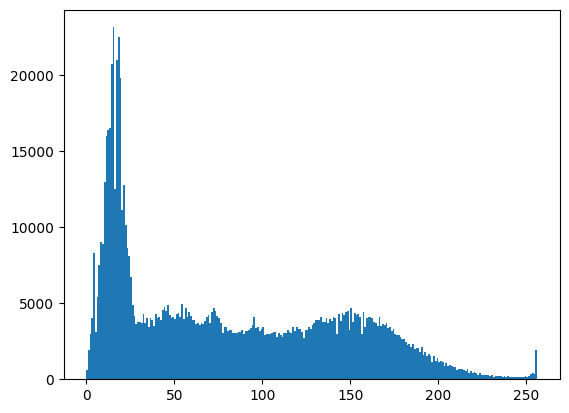

In [2]:
img=cv2.imread("F:/ComputerVision/Data/dianbiao/dianbiao1.jpg")
img1=np.copy(img)
HistShow(img)
cvShow('ori',img)

滤波操作去噪

In [3]:
#对于不同的图像选择使用高斯滤波，原图高分辨率可用，低分辨率不可用
img1=cv2.GaussianBlur(img1,(5,5),0,0)
#cvShow('gaus',img1)
#对原图像进行一个滤波操作模糊噪点，保留边缘信息
img1=cv2.bilateralFilter(img1, 15, 75,100)
cvShow('bila',img1)

In [4]:
#转灰度
imgG=cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
imgG1=np.copy(imgG)
cvShow('Gray',imgG)

接下来进行阈值分割操作，再绘画轮廓

In [5]:
threshAm=cv2.adaptiveThreshold(imgG,255,cv2.ADAPTIVE_THRESH_MEAN_C,
                                  cv2.THRESH_BINARY_INV,101,5)
cvShow('threA',threshAm)
contours,hierarchy=cv2.findContours(threshAm,cv2.RETR_TREE,
                                    cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(img1,contours,-1,(0,255,0),2)
cvShow('outline',img1)
img1=np.copy(img)

消除轮廓中的类似噪点的元素

In [6]:
CtoL=DelNoise(contours,20)
cv2.drawContours(img1,tuple(CtoL),-1,(0,255,0),2)
cvShow('outline',img1)
img1=np.copy(img)

通过多边形近似获取包含数字的框

In [7]:
#轮廓近似，epsilon为准确度参数，epsilon的值越小，多边形逼近更准确
approx=[0]*len(CtoL)
epsilon=11
for i in range(len(CtoL)):
    #第一个参数是要逼近的轮廓，第二个参数是准确值，第三个参数是设定弧线是否闭合
    approx[i]=cv2.approxPolyDP(CtoL[i],epsilon,True)
    cv2.drawContours(img1,[approx[i]],-1,(0,255,0),3)
#绘制近似轮廓
cvShow('approx',img1)
img1=np.copy(img)

对轮廓面积从大到小进行一个排序

In [8]:
area=np.zeros(len(approx))
#对轮廓面积从大到小进行一个排序
for i in range(len(approx)):
    area[i]=cv2.contourArea(approx[i])
area=sorted(area,reverse=True)
sort=[0]*len(approx)
j=0
while(j<len(area)):
    i=0
    for i in range(len(approx)):
        if cv2.contourArea(approx[i])==area[j]:
            sort[j]=i
            break
    j=j+1

按照轮廓面积从大到小遍历，取最大的四边形轮廓作为图像ROI

In [9]:
cnt=np.array([])
for i in range(len(sort)):
    if len(approx[sort[i]])==4:
        cnt=approx[sort[i]]
        break
cv2.drawContours(img1,[cnt],-1,(0,255,0),3)
cvShow('approx',img1)
img1=np.copy(img)

通过四边形轮廓定位四个坐标进行ROI并且统一大小

In [10]:
x1=min(cnt[0][0][0],cnt[1][0][0])
x2=max(cnt[2][0][0],cnt[3][0][0])
y1=min(cnt[0][0][1],cnt[3][0][1])
y2=max(cnt[1][0][1],cnt[2][0][1])
print(x1,x2,y1,y2)
#图像ROI
roi=img1[y1:y2,x1:x2]
#统一大小
roi=cv2.resize(roi,(500,125))
cvShow('roi',roi)

31 346 152 219


在一次图像ROI调整分辨率后进行一次图像增强

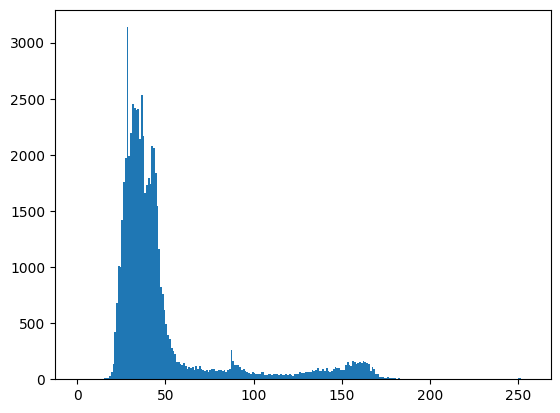

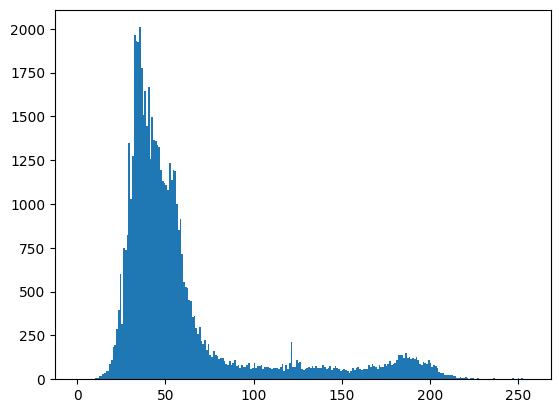

In [12]:
#转灰度
roi1=np.copy(roi)
roiG=cv2.cvtColor(roi,cv2.COLOR_BGR2GRAY)
HistShow(roiG)
cvShow('roiG',roiG)
#ROI之后进行一次图像增强，此处为局部直方图均衡化
clache=cv2.createCLAHE(clipLimit=2.0,tileGridSize=(8,8))
roiG=clache.apply(roiG)
HistShow(roiG)
cvShow('His',roiG)

开始寻找数字轮廓，利用阈值分割寻找轮廓的外接矩形

In [14]:
#使用阈值分割
ret,thresh=cv2.threshold(roiG,155,255,cv2.THRESH_BINARY_INV)
cvShow('thre',thresh)
contours,hierarchy=cv2.findContours(thresh,cv2.RETR_TREE,
                                    cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(roi1,contours,-1,(0,255,0),2)
cvShow('thre',roi1)
roi1=np.copy(roi)
#去除噪声轮廓
CtoL=DelNoise(contours,200)
cv2.drawContours(roi1,tuple(CtoL),-1,(0,255,0),2)
cvShow('Noutline',roi1)
roi1=np.copy(roi)

先画出目前所有轮廓的外接矩形用于调试

In [15]:
bounding_boxes=[cv2.boundingRect(c) for c in CtoL]
i=0
while i<(len(bounding_boxes)):
    [x,y,w,h]=bounding_boxes[i]
    cv2.rectangle(roi1,(x,y),(x+w,y+h),(0,255,0),2)
    i=i+1
    
cvShow('rec',roi1)
roi1=np.copy(roi)

获取轮廓的外接正四边形用于数字ROI

In [16]:
bounding_boxes=[cv2.boundingRect(c) for c in CtoL]
i=0
while i<(len(bounding_boxes)):
    [x,y,w,h]=bounding_boxes[i]
    #先排除长宽比不符合数字特征的外接矩形
    if w>h:
        del bounding_boxes[i]
    else:
        cv2.rectangle(roi1,(x,y),(x+w,y+h),(0,255,0),2)
        i=i+1
        
cvShow('rec',roi1)
roi1=np.copy(roi)

删除在其他外接矩形内部的矩形

In [17]:
i=0
while i<(len(bounding_boxes)):
    [xi,yi,wi,hi]=bounding_boxes[i]
    j=0
    while j<(len(bounding_boxes)):
        [xj,yj,wj,hj]=bounding_boxes[j]
        if xi<=xj and xi+wi>xj+wj and yi<=yj and yi+hi>yj+hj:
            del bounding_boxes[j]
        else:
            j=j+1
    i=i+1
print(bounding_boxes)
i=0
while i<(len(bounding_boxes)):
    [x,y,w,h]=bounding_boxes[i]
    cv2.rectangle(roi1,(x,y),(x+w,y+h),(0,255,0),2)
    i=i+1
cvShow('rec',roi1)
roi1=np.copy(roi)

[(350, 43, 28, 51), (280, 43, 17, 49), (202, 35, 31, 56), (419, 34, 28, 45), (123, 31, 30, 58), (41, 29, 30, 57)]


删除面积太小的轮廓

In [19]:
i=0
while i<(len(bounding_boxes)):
    [xi,yi,wi,hi]=bounding_boxes[i]
    square=wi*hi
    if square<800:
        del bounding_boxes[i]
    else:
        cv2.rectangle(roi1,(xi,yi),(xi+wi,yi+hi),(0,255,0),2)
        i=i+1
cvShow('rec',roi1)
roi1=np.copy(roi)

实现数字ROI

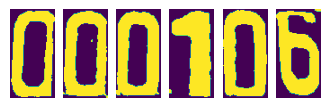

In [20]:
#将数字的外接矩形从左到右排序
bounding_boxes=sorted(bounding_boxes)

#ROI之后进行一次图像增强
clache=cv2.createCLAHE(clipLimit=2.0,tileGridSize=(8,8))
#用列表将数字ROI图片存起来
num=[0]*len(bounding_boxes)
for i in range(len(bounding_boxes)):
    [x,y,w,h]=bounding_boxes[i]
    #图像ROI
    num[i]=roi1[y:y+h,x:x+w]
    #统一大小
    num[i]=cv2.resize(num[i],(50,100))
    #转灰度
    num[i]=cv2.cvtColor(num[i],cv2.COLOR_BGR2GRAY)
    cvShow('numGray',num[i])
    #ROI之后进行一次图像增强，此处为局部直方图均衡化
    num[i]=clache.apply(num[i])
    cvShow('His',num[i])
    #二值化
    ret,num[i]=cv2.threshold(num[i],120,255,cv2.THRESH_BINARY)
    cvShow('numthre',num[i])
#显示数字ROI
fig,ax=plt.subplots(1,len(num),figsize=(4,8))
plt.axis('off')
for i in range(len(num)):
    ax[i].imshow(num[i])
    ax[i].set_axis_off()

批量读入训练数据

In [21]:
import skimage.io as io
from skimage import data_dir
import os 

In [22]:
#预先初始化分配内存，解决赋值内存空间混乱问题
train_data=[0]*10
for i in range(10):
    train_data[i]=[0 for i in range(10)]

coll=[0]*10

root_dir=os.listdir("F:/ComputerVision/Class/shiyan5/digitaldetection/data")
for i in range(len(root_dir)):
    pathname=os.path.join("F:/ComputerVision/Class/shiyan5/digitaldetection/data",root_dir[i])
    str=pathname+ '/*.bmp'
    coll[i]=io.ImageCollection(str)
    #统一训练数据和测试数据的大小
    for j in range(len(coll[i])):
        train_data[i][j]=cv2.resize(coll[i][j],(num[0].shape[1],num[0].shape[0]))

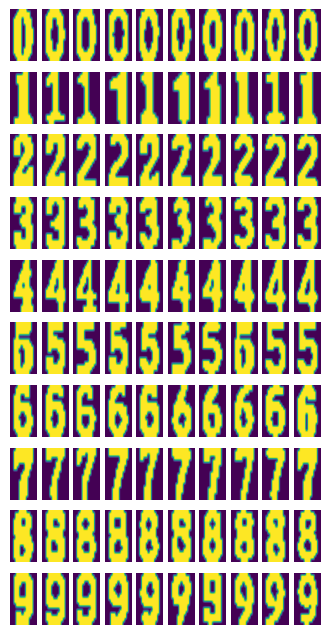

In [329]:
#显示训练数据
fig,ax=plt.subplots(10,10,figsize=(4,8))
plt.axis('off')
for i in range(10):
    for j in range(10):
        ax[i][j].imshow(np.uint8(train_data[i][j]))
        ax[i][j].set_axis_off()

利用读入的训练数据构造训练集

In [23]:
trainData=np.zeros((100,len(train_data[0][0].ravel())))
#共有100个训练数据，每个数字10个，将每个数字图像的二维矩阵转化为一维行向量
for i in range(len(train_data)):
    for j in range(len(train_data[i])):
        trainData[i*10+j]=train_data[i][j].ravel()
trainData=np.float32(trainData)
#获得100(数据图像总数)个行向量，每个行向量有像素点总数个元素
trainData.shape

(100, 5000)

构造训练集标签

In [24]:
labels=np.zeros((100,1))
j=0
for i in range(len(labels)):
    if int(i/10)>j:
        j=j+1
    labels[i]=j
labels=np.float32(labels)

利用之前获取的数字ROI图片构造预测集

In [25]:
predictData=np.zeros((len(num),len(train_data[0][0].ravel())))
for i in range(len(num)):
    predictData[i]=num[i].ravel()
predictData=np.float32(predictData)
predictData.shape

(6, 5000)

构造k近邻分类器

In [26]:
knn=cv2.ml.KNearest_create()
knn.train(trainData,cv2.ml.ROW_SAMPLE,labels)

True

In [27]:
ret,results,neighbours,dist=knn.findNearest(predictData,5)

In [28]:
print ("results: \n", results,"\n")
print ("neighbours: \n", neighbours,"\n")
print ("distances: \n", dist)

results: 
 [[0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [6.]] 

neighbours: 
 [[0. 0. 5. 5. 0.]
 [0. 0. 0. 9. 5.]
 [0. 0. 0. 9. 9.]
 [1. 1. 1. 3. 3.]
 [0. 0. 0. 9. 3.]
 [6. 6. 0. 6. 5.]] 

distances: 
 [[1.01384392e+08 1.16945936e+08 1.19742944e+08 1.19742944e+08
  1.21722168e+08]
 [9.62043440e+07 1.13321344e+08 1.17483576e+08 1.18569080e+08
  1.24078352e+08]
 [9.03186480e+07 1.05285952e+08 1.09662856e+08 1.10487448e+08
  1.15154680e+08]
 [4.63177240e+07 6.18215680e+07 7.07862720e+07 7.83772320e+07
  7.83772320e+07]
 [9.64654800e+07 1.11597056e+08 1.16533416e+08 1.17505288e+08
  1.21895072e+08]
 [9.53088960e+07 9.59916480e+07 9.60839760e+07 9.89245600e+07
  9.89542880e+07]]


In [29]:
string=""
for i in range(len(results)):
    string=string+'%d'%(results[i][0])
print(string)

000106


In [30]:
img1=cv2.putText(img1,string,(10,50),cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),2)
cvShow('result',img1)
img1=np.copy(img)